In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [20, 40]

In [2]:
data_set = pd.read_csv("Google_Stock_Price_Train.csv")
data_set.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


- Data preprocesing

------

In [3]:
data_set.shape

(1258, 6)

In [4]:
data_set = data_set.iloc[:,1:4].values
data_set

array([[325.25, 332.83, 324.97],
       [331.27, 333.87, 329.08],
       [329.83, 330.75, 326.89],
       ...,
       [793.7 , 794.23, 783.2 ],
       [783.33, 785.93, 778.92],
       [782.75, 782.78, 770.41]])

In [5]:
data_set = np.array([[i,j-k]for i,j,k in data_set])
data_set

array([[325.25,   7.86],
       [331.27,   4.79],
       [329.83,   3.86],
       ...,
       [793.7 ,  11.03],
       [783.33,   7.01],
       [782.75,  12.37]])

Target interval = 1

In [6]:
X_data = data_set[0:1257]
y_data = data_set[1:1258,0:1]

In [7]:
X_sc = MinMaxScaler() # default is 0,1
X_data = X_sc.fit_transform(X_data)

In [8]:
y_sc = MinMaxScaler() # default is 0,1
y_data = y_sc.fit_transform(y_data)

- x_dim =2

In [9]:
X_data

array([[0.08581368, 0.11558367],
       [0.09701243, 0.05673759],
       [0.09433366, 0.03891125],
       ...,
       [0.95163331, 0.16043703],
       [0.95725128, 0.17634656],
       [0.93796041, 0.09929078]])

In [10]:
y_data

array([[0.09701243],
       [0.09433366],
       [0.09156187],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [11]:
# hyperparameters
seq_length =7 # max sequence
b_size = 35 # batch size
state_size = 4 # hidden node size 
input_dim = X_data.shape[1] # 2
output_dim = y_data.shape[1] # 1

In [12]:
print('# of paired dataset', len(y_data)-seq_length)

# of paired dataset 1250


In [13]:
data_X = []
data_y = []
for i in range(0, len(y_data) - seq_length):
    _X_data = X_data[i:i+seq_length]
    _y_data = y_data[i+seq_length]
    data_X.append(_X_data)
    data_y.append(_y_data)
    if i%1000 ==0:
        print(_X_data, "->", _y_data)

[[0.08581368 0.11558367]
 [0.09701243 0.05673759]
 [0.09433366 0.03891125]
 [0.09156187 0.06248802]
 [0.07984225 0.21084915]
 [0.0643277  0.12631781]
 [0.0585423  0.04389496]] -> [0.06109085]
[[0.88241313 0.16062871]
 [0.87512092 0.0555875 ]
 [0.88138998 0.22311673]
 [0.90700573 0.22465018]
 [0.92544088 0.17002108]
 [0.91223305 0.17883841]
 [0.86293623 0.2102741 ]] -> [0.83875288]


In [14]:
X_trn, X_tst, y_trn, y_tst = train_test_split(data_X, data_y, 
                                              test_size=0.3, 
                                              random_state=42,
                                              shuffle=False
                                              )
print('X_train:', len(X_trn))
print('y_train:', len(y_trn))
print('X_test:', len(X_tst))
print('y_test:', len(y_tst))

X_train: 875
y_train: 875
X_test: 375
y_test: 375


- graph로 통과시킬 변수 선언

In [15]:
X = tf.placeholder(tf.float32, [None, seq_length, input_dim])
y = tf.placeholder(tf.float32, [None, 1])
lr = tf.placeholder(tf.float32)
batch_size = tf.placeholder(tf.int32,[]) # [] important

In [16]:
print(X)
print(y)

Tensor("Placeholder:0", shape=(?, 7, 2), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


- tf를 사용하게 되면 init state를 placeholder로 선언하지 않아도 됨
- 하지만 init state에 대한 batch_size를 선언해 주어서 유동적으로 바꿔주게 됨 

- 각 sequence마다 input을 연산하기 위해 split적용
- X $\in \mathbb{R}^{?\times 7 \times 2}$

In [17]:
_inputs_series = tf.split(value=X, num_or_size_splits=seq_length, axis=1)
_inputs_series

[<tf.Tensor 'split:0' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:1' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:2' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:3' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:4' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:5' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:6' shape=(?, 1, 2) dtype=float32>]

- Since *tf* is going to expect 2d-array

In [18]:
inputs_series= [tf.squeeze(inputs,axis=1) for inputs in _inputs_series]
inputs_series

[<tf.Tensor 'Squeeze:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Squeeze_1:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Squeeze_2:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Squeeze_3:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Squeeze_4:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Squeeze_5:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Squeeze_6:0' shape=(?, 2) dtype=float32>]

y $\in \mathbb{R}^{?}$

In [19]:
labels_series = tf.unstack(y, axis=1)
labels_series

[<tf.Tensor 'unstack:0' shape=(?,) dtype=float32>]

- RNN network

In [20]:
# forward pass
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=state_size)
cell

In [21]:
batch_size

<tf.Tensor 'Placeholder_3:0' shape=() dtype=int32>

- [batch_size , state_size]

In [22]:
init_state = cell.zero_state(batch_size, tf.float32)
init_state

<tf.Tensor 'BasicRNNCellZeroState/zeros:0' shape=(?, 4) dtype=float32>

In [23]:
states_series, current_state = tf.nn.static_rnn(cell=cell,
                                                inputs=inputs_series, # (batch x input) szie
                                                initial_state = init_state)

In [24]:
states_series

[<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_1:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_2:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_3:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_4:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_5:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_6:0' shape=(?, 4) dtype=float32>]

In [25]:
# last hidden state
current_state

<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_6:0' shape=(?, 4) dtype=float32>

In [26]:
states_series = tf.concat([tf.expand_dims(state,1) for state in states_series], axis=1)
states_series

<tf.Tensor 'concat:0' shape=(?, 7, 4) dtype=float32>

In [27]:
# last hidden state
states_series[:,-1]

<tf.Tensor 'strided_slice:0' shape=(?, 4) dtype=float32>

- loss function

In [28]:
# with last hidden state
y_pred = tf.layers.dense(states_series[:,-1], output_dim, activation=None)
y_pred

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [29]:
loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

In [30]:
sess = tf.Session()
init = tf.global_variables_initializer()

In [31]:
sess.run(init)

0th loss: 0.014015709049999714
1000th loss: 0.00044476776383817196
2000th loss: 0.0005492198979482055
3000th loss: 0.0005633618566207588
4000th loss: 0.000359589874278754
5000th loss: 0.000976364768575877
6000th loss: 0.0007196559454314411


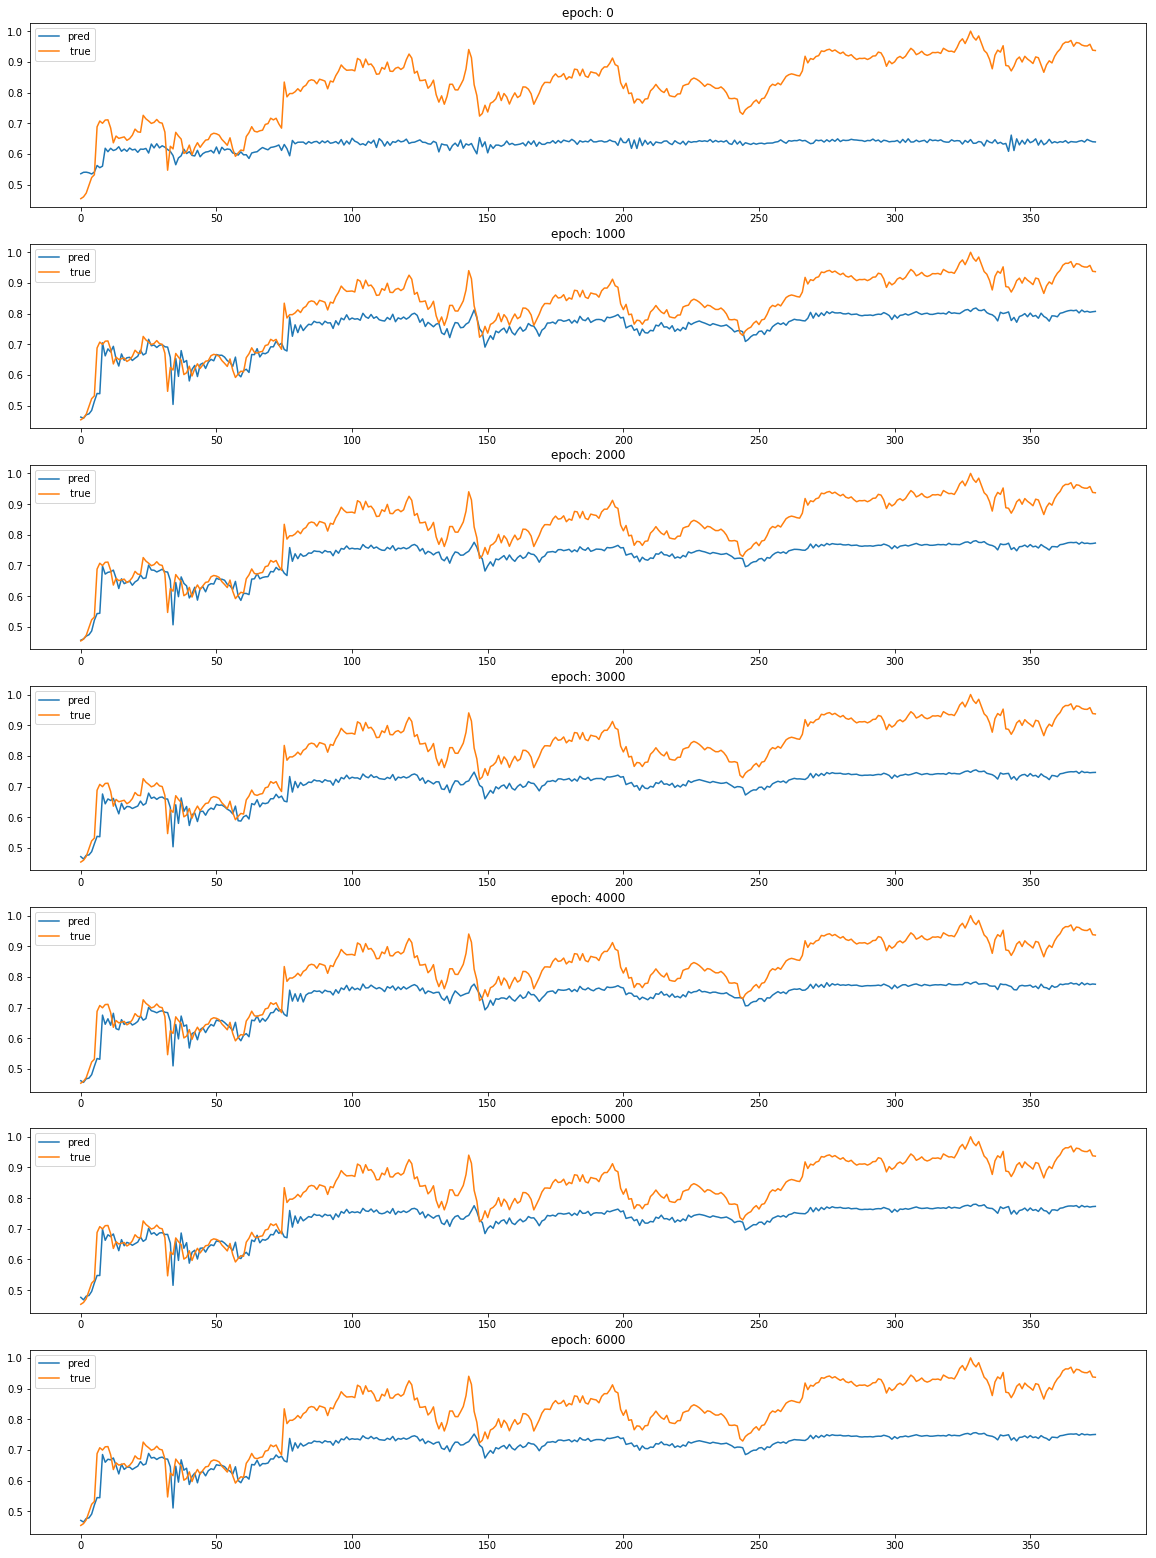

In [34]:
ix=1


for i in range(7000):

    for k in range(math.ceil(len(X_trn)/b_size)):
        start = k*b_size
        end = (k*b_size)+b_size
        _ , _loss, _current_state = sess.run([train_op, loss, current_state], 
                 feed_dict={lr:0.01,
                            X: X_trn[start:end],
                            y: y_trn[start:end],
                            batch_size: b_size
                           })

    if i % 1000==0:
        print('{}th loss: {}'.format(i,_loss))
        
        plt.subplot(10,1,ix)
        
        total_y_pred = []
        for k in range(math.ceil((len(X_tst)/b_size))):
            start = k*b_size
            end = (k*b_size)+b_size
       
            _y_pred = sess.run(y_pred, feed_dict={ X: X_tst[start:end],
                                                 batch_size: len(X_tst[start:end])})
            total_y_pred.extend(_y_pred)
        
        total_y_pred = np.array(total_y_pred)
        
        tst_loss = np.mean(np.abs(total_y_pred-y_tst))
        plt.plot(total_y_pred, label ='pred')
        plt.plot(y_tst, label = ' true')
        plt.legend()
        plt.title('epoch: {}'.format(i))
        
        ix+=1

- y 복원예측하는 방법

In [35]:
y_sc.inverse_transform(_y_pred)[0:5]

array([[680.58453],
       [677.0774 ],
       [678.2046 ],
       [675.5092 ],
       [680.47534]], dtype=float32)

In [36]:
tst_loss

0.11277691671566045

In [37]:
y_sc.inverse_transform(tst_loss)

array([[339.74435935]])

---------